# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [2]:
def grow_tree(data, depth=0, max_depth=10, criterion="gini"):
    # TODO: Implement the rest of this function.
    # NOTE: You will need to come back to this function to make use of later functions.
    class_labels = data[:,-1]
    features = data[:,:-1]
    # Check stopping criteria and create a leaf if any is true
    # if all data are of the same class it is homogeneous
    if (
        homogeneous(class_labels)
        or is_max_depth(depth, max_depth)
        or min_samples_split(features)
        or unbalanced(class_labels)
    ):
        return {"leaf_value": majority_label(class_labels)}  # Don't grow the tree

    best_feature_idx, best_threshold = best_split(
        features, class_labels, criterion
    )  # split on feature that creates most homogenous data subsets.
    if best_feature_idx is None:
        # Could not find a better split
        return {"leaf_value": majority_label(class_labels)}  # Don't grow the tree

    left_data, right_data = split_data(data, features, best_feature_idx, best_threshold)

    if len(left_data) != 0:
        left_subtree = grow_tree(left_data, depth+1, max_depth)
    else:
        return {"leaf_value": majority_label(class_labels)}  # Don't grow the tree

    if len(right_data) != 0:
        right_subtree = grow_tree(right_data, depth+1, max_depth)
    else:
        return {"leaf_value": majority_label(class_labels)}  # Don't grow the tree

    # Return a node
    return {
        "feature_idx": best_feature_idx,
        "threshold": best_threshold,
        "left": left_subtree,
        "right": right_subtree,
    }

In [3]:
def majority_label(class_labels):
    unique_classes, counts = np.unique(class_labels, return_counts=True)
    return unique_classes[np.argmax(counts)]

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

- Stop if the split doesn't significantly reduce impurity.  
- Stop if training exceeds a time limit.  
- Early stopping based on validation performance (prevent overfitting once performance plateaus).  
- Stop if further splits yield minimal improvement.

In [4]:
# TODO: Change the name of the functions and implement them as you see fit.
# 1. When a node has only datapoints of a single class.
def homogeneous(class_labels):
    # NOTE: it is up to me to decide if all labels has to be of the same class or for example 90% to prevent overfitting and too deep and specialized trees.

    # Check if all class labels are the same
    return len(np.unique(class_labels)) == 1

# 2. Prevent the tree from growing to large, i.e., a max depth.
def is_max_depth(depth, max_depth):
    return depth >= max_depth

# 3. Prevent the tree nodes from becoming to small.
def min_samples_split(features):
    return len(features) < 2

# 4. Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extension to case 1.
def unbalanced(class_labels, size_threshold=100, ratio_threshold=0.9):
    _, counts = np.unique(class_labels, return_counts=True)
    max_count = np.max(counts)
    return (
        len(class_labels) > size_threshold
        and (max_count / len(class_labels)) >= ratio_threshold
    )

# Add more stopping criteria if needed. Don't forget to use them when growing the tree!

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achieved by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [5]:
def information_entropy(class_labels):
    size_labels = len(class_labels)
    if size_labels == 0:
        return 0

    _, counts = np.unique(class_labels, return_counts=True)
    probabilities = counts / size_labels
    return -sum(probabilities * np.log2(probabilities))

In [6]:
def gini_impurity(class_labels):
    size_labels = len(class_labels)
    if size_labels == 0:
        return 0

    _, counts = np.unique(class_labels, return_counts=True)
    probabilities = counts / size_labels
    return 1 - np.sum(probabilities**2)

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [7]:
def best_split(features, class_labels, criterion):
    best_weighted_gain = 0
    best_feature_idx = best_threshold = None
    n_features = features.shape[1]
    
    if criterion == "gini": current_impurity = gini_impurity(class_labels)
    else: current_impurity = information_entropy(class_labels)
    for feature_idx in range(n_features):
        feature_col = features[:, feature_idx]
        if isinstance(features[0][feature_idx], (int, float, np.float64)):
            threshold = np.mean(feature_col.astype(np.float64))
            left_mask = feature_col.astype(np.float64) < threshold
            right_mask = ~left_mask

            left_labels = class_labels[left_mask]
            right_labels = class_labels[right_mask]

            weighted_left = len(left_labels) / len(class_labels)
            weighted_right = len(right_labels) / len(class_labels)

            if criterion == "gini":
                gini_left = gini_impurity(left_labels)
                gini_right = gini_impurity(right_labels)
                weighted_gain = current_impurity - (weighted_left * gini_left + weighted_right * gini_right)
            else:
                entropy_left = information_entropy(left_labels)
                entropy_right = information_entropy(right_labels)
                weighted_gain = current_impurity - (weighted_left * entropy_left + weighted_right * entropy_right)


            if weighted_gain > best_weighted_gain:
                best_weighted_gain = weighted_gain
                best_feature_idx = feature_idx
                best_threshold = threshold

        else:
            categories = np.unique(feature_col)
            for cat in categories:
                left_mask = feature_col == cat
                right_mask = ~left_mask

                left_labels = class_labels[left_mask]
                right_labels = class_labels[right_mask]

                weighted_left = len(left_labels) / len(class_labels)
                weighted_right = len(right_labels) / len(class_labels)

                if criterion == "gini":
                    gini_left = gini_impurity(left_labels)
                    gini_right = gini_impurity(right_labels)
                    weighted_gain = current_impurity - (weighted_left * gini_left + weighted_right * gini_right)
                else:
                    entropy_left = information_entropy(left_labels)
                    entropy_right = information_entropy(right_labels)
                    weighted_gain = current_impurity - (weighted_left * entropy_left + weighted_right * entropy_right)


                if weighted_gain > best_weighted_gain:
                    best_weighted_gain = weighted_gain
                    best_feature_idx = feature_idx
                    best_threshold = cat

    return best_feature_idx, best_threshold 

In [8]:
def split_data(data, features, feature_idx, threshold):
    # TODO: Implement the rest of this function.
    feature_col = features[:, feature_idx]

    if isinstance(features[0][feature_idx], (int, float, np.float64)):
        left_mask = feature_col.astype(np.float64) < threshold
        right_mask = ~left_mask
    else:
        left_mask = features[:, feature_idx] == threshold
        right_mask = ~left_mask

    left_data = data[left_mask]
    right_data = data[right_mask]
    return left_data, right_data

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [9]:
def predict_with_tree(features, test, tree):
    # TODO: Implement the rest of this function.
    # NOTE: This function should also be recursive.
    if "leaf_value" in tree:
        return tree["leaf_value"]

    feature_idx = tree["feature_idx"]
    threshold = tree["threshold"]

    if isinstance(features[0][feature_idx], (int, float, np.float64)):
        if np.float64(test[feature_idx]) < np.float64(threshold):
            return predict_with_tree(features, test, tree["left"])
        else:
            return predict_with_tree(features, test, tree["right"])
    else:
        if test[feature_idx] == threshold:
            return predict_with_tree(features, test, tree["left"])
        else:
            return predict_with_tree(features, test, tree["right"])

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [10]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [11]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

My Tree Wine Accuracy: 0.9777777777777777   Sklearn Tree Wine Accuracy: 0.8666666666666667  
My Tree Wine Accuracy: 0.8888888888888888   Sklearn Tree Wine Accuracy: 0.8444444444444444  
My Tree Wine Accuracy: 0.9555555555555556   Sklearn Tree Wine Accuracy: 0.9333333333333333  
My Tree Wine Accuracy: 0.9333333333333333   Sklearn Tree Wine Accuracy: 0.9111111111111111  
My Tree Wine Accuracy: 0.8444444444444444   Sklearn Tree Wine Accuracy: 0.9111111111111111  
My Tree Wine Accuracy: 0.9555555555555556   Sklearn Tree Wine Accuracy: 0.8666666666666667  
My Tree Wine Accuracy: 0.9333333333333333   Sklearn Tree Wine Accuracy: 0.9333333333333333  
My Tree Wine Accuracy: 0.8666666666666667   Sklearn Tree Wine Accuracy: 0.9555555555555556  
My Tree Wine Accuracy: 0.9333333333333333   Sklearn Tree Wine Accuracy: 0.8                 
My Tree Wine Accuracy: 0.9333333333333333   Sklearn Tree Wine Accuracy: 0.9333333333333333  

My Tree Wine Mean and Median Accuracy: 0.9222222222222223 0.933333333

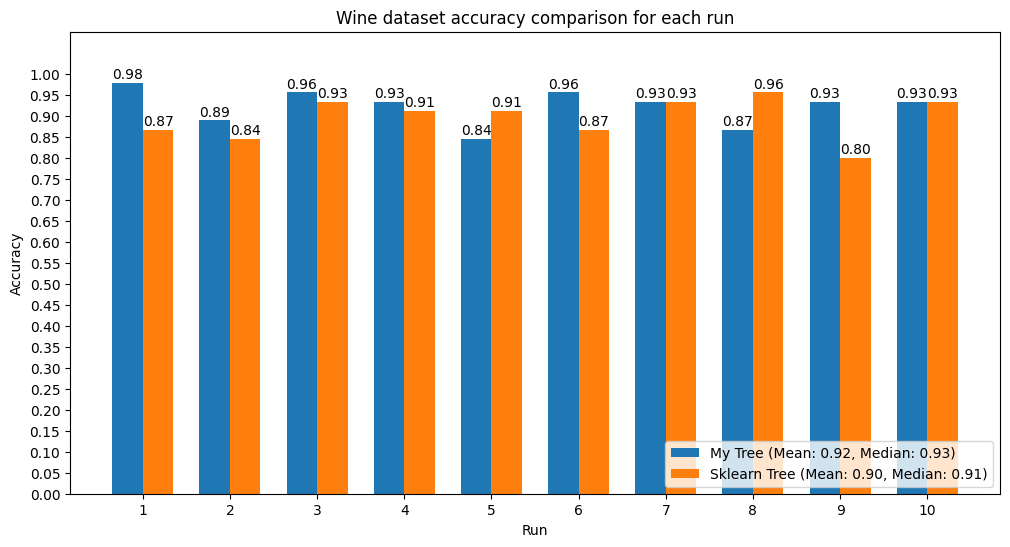

In [12]:
data_wine = pd.read_csv("wine.csv", skiprows=[1]).to_numpy()

accuracies_my_tree = []
accuracies_sklearn_tree = []

# TODO: Set up the data and split it into train and test-sets.
data_wine_features = data_wine[:, :-1]
data_wine_labels = data_wine[:, -1]

for _ in range(10):
    train_features, test_features, train_labels, test_labels = train_test_split(data_wine_features, data_wine_labels, test_size=0.25, train_size=0.75, shuffle=True)

    data = np.column_stack((train_features, train_labels))

    # TODO: Train and test your implemented tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model
    predictions = []

    my_tree = grow_tree(data, 0, 10, criterion="gini")

    for feature_row in test_features:
        prediction = predict_with_tree(train_features, feature_row, my_tree)
        predictions.append(prediction)

    accuracy_my_tree = accuracy_score(test_labels, predictions)
    accuracies_my_tree.append(accuracy_my_tree)
    # TODO: Train and test scikit learns tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model
    decision_tree_classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=2
    )
    decision_tree_classifier.fit(train_features, train_labels)
    sklearn_predictions = decision_tree_classifier.predict(test_features)
    accuracy_sklearn = accuracy_score(test_labels, sklearn_predictions)
    accuracies_sklearn_tree.append(accuracy_sklearn)
    print(
        f"My Tree Wine Accuracy: {accuracy_my_tree:<20} Sklearn Tree Wine Accuracy: {accuracy_sklearn:<20}"
    )

mean_accuracy_my_tree = np.mean(accuracies_my_tree)
median_accuracy_my_tree = np.median(accuracies_my_tree)
mean_accuracy_sklearn_tree = np.mean(accuracies_sklearn_tree)
median_accuracy_sklearn_tree = np.median(accuracies_sklearn_tree)

print("\nMy Tree Wine Mean and Median Accuracy:", mean_accuracy_my_tree, median_accuracy_my_tree)
print(
    "Sklearn Tree Wine Mean and Median Accuracy:",
    mean_accuracy_sklearn_tree,
    median_accuracy_sklearn_tree,
)


# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(12, 6))
x = np.arange(1, 11)
width = 0.35

plt.bar(
    x - width / 2,
    accuracies_my_tree,
    width,
    label=f"My Tree (Mean: {mean_accuracy_my_tree:.2f}, Median: {median_accuracy_my_tree:.2f})",
)
plt.bar(
    x + width / 2,
    accuracies_sklearn_tree,
    width,
    label=f"Sklearn Tree (Mean: {mean_accuracy_sklearn_tree:.2f}, Median: {median_accuracy_sklearn_tree:.2f})",
)

for i in range(10):
    plt.text(
        x[i] - width / 2,
        accuracies_my_tree[i] + 0.01,
        f"{accuracies_my_tree[i]:.2f}",
        ha="center",
    )
    plt.text(
        x[i] + width / 2,
        accuracies_sklearn_tree[i] + 0.01,
        f"{accuracies_sklearn_tree[i]:.2f}",
        ha="center",
    )

plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.title("Wine dataset accuracy comparison for each run")
plt.xticks(x)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim([0, 1.1])
plt.legend(loc='lower right')
plt.show()

### 7) Dataset 2: Heart Disease

My Tree Heart Accuracy: 0.9688715953307393   Sklearn Tree Heart Accuracy: 0.9883268482490273  
My Tree Heart Accuracy: 0.9883268482490273   Sklearn Tree Heart Accuracy: 1.0                 
My Tree Heart Accuracy: 0.9649805447470817   Sklearn Tree Heart Accuracy: 0.9883268482490273  
My Tree Heart Accuracy: 0.9455252918287937   Sklearn Tree Heart Accuracy: 0.9883268482490273  
My Tree Heart Accuracy: 0.9649805447470817   Sklearn Tree Heart Accuracy: 0.9883268482490273  
My Tree Heart Accuracy: 0.980544747081712    Sklearn Tree Heart Accuracy: 1.0                 
My Tree Heart Accuracy: 0.9377431906614786   Sklearn Tree Heart Accuracy: 0.9883268482490273  
My Tree Heart Accuracy: 0.9377431906614786   Sklearn Tree Heart Accuracy: 0.9883268482490273  
My Tree Heart Accuracy: 0.933852140077821    Sklearn Tree Heart Accuracy: 0.9883268482490273  
My Tree Heart Accuracy: 0.9299610894941635   Sklearn Tree Heart Accuracy: 0.9844357976653697  

My Tree Heart Mean and Median Accuracy: 0.9552529

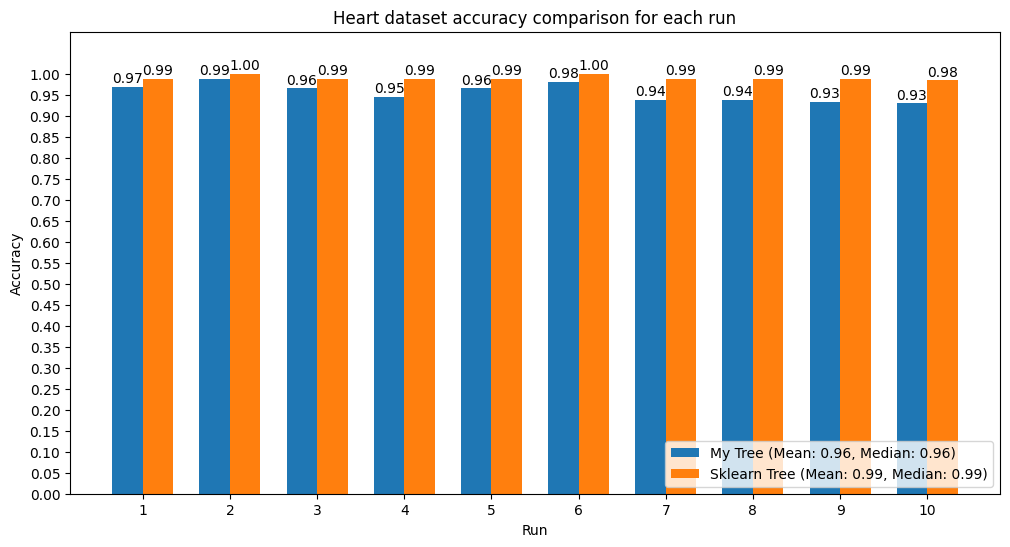

In [13]:
data_heart = pd.read_csv("heart.csv").to_numpy()

accuracies_my_tree = []
accuracies_sklearn_tree = []

# TODO: Set up the data and split it into train and test-sets.
data_heart_features = data_heart[:, :-1]
data_heart_labels = data_heart[:, -1]

for _ in range(10):
    train_features, test_features, train_labels, test_labels = train_test_split(
        data_heart_features,
        data_heart_labels,
        test_size=0.25,
        train_size=0.75,
        shuffle=True,
    )

    data = np.column_stack((train_features, train_labels))

    # TODO: Train and test your implemented tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model
    predictions = []

    my_tree = grow_tree(data, 0, 10, criterion="gini")

    for feature_row in test_features:
        prediction = predict_with_tree(train_features, feature_row, my_tree)
        predictions.append(prediction)

    accuracy_my_tree = accuracy_score(test_labels, predictions)
    accuracies_my_tree.append(accuracy_my_tree)
    # TODO: Train and test scikit learns tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model
    decision_tree_classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=2)
    decision_tree_classifier.fit(train_features, train_labels)
    sklearn_predictions = decision_tree_classifier.predict(test_features)
    accuracy_sklearn = accuracy_score(test_labels, sklearn_predictions)
    accuracies_sklearn_tree.append(accuracy_sklearn)
    print(
        f"My Tree Heart Accuracy: {accuracy_my_tree:<20} Sklearn Tree Heart Accuracy: {accuracy_sklearn:<20}"
    )

mean_accuracy_my_tree = np.mean(accuracies_my_tree)
median_accuracy_my_tree = np.median(accuracies_my_tree)
mean_accuracy_sklearn_tree = np.mean(accuracies_sklearn_tree)
median_accuracy_sklearn_tree = np.median(accuracies_sklearn_tree)

print(
    "\nMy Tree Heart Mean and Median Accuracy:",
    mean_accuracy_my_tree,
    median_accuracy_my_tree,
)
print(
    "Sklearn Tree Heart Mean and Median Accuracy:",
    mean_accuracy_sklearn_tree,
    median_accuracy_sklearn_tree,
)


# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(12, 6))
x = np.arange(1, 11)
width = 0.35

plt.bar(
    x - width / 2,
    accuracies_my_tree,
    width,
    label=f"My Tree (Mean: {mean_accuracy_my_tree:.2f}, Median: {median_accuracy_my_tree:.2f})",
)
plt.bar(
    x + width / 2,
    accuracies_sklearn_tree,
    width,
    label=f"Sklearn Tree (Mean: {mean_accuracy_sklearn_tree:.2f}, Median: {median_accuracy_sklearn_tree:.2f})",
)

for i in range(10):
    plt.text(
        x[i] - width / 2,
        accuracies_my_tree[i] + 0.01,
        f"{accuracies_my_tree[i]:.2f}",
        ha="center",
    )
    plt.text(
        x[i] + width / 2,
        accuracies_sklearn_tree[i] + 0.01,
        f"{accuracies_sklearn_tree[i]:.2f}",
        ha="center",
    )

plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.title("Heart dataset accuracy comparison for each run")
plt.xticks(x)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim([0, 1.1])
plt.legend(loc="lower right")
plt.show()

### 8) Dataset 3: Car

My Tree Car Accuracy: 0.9513888888888888   Sklearn Tree Car Accuracy: 0.9699074074074074  
My Tree Car Accuracy: 0.9583333333333334   Sklearn Tree Car Accuracy: 0.9606481481481481  
My Tree Car Accuracy: 0.9699074074074074   Sklearn Tree Car Accuracy: 0.9652777777777778  
My Tree Car Accuracy: 0.9513888888888888   Sklearn Tree Car Accuracy: 0.9768518518518519  
My Tree Car Accuracy: 0.9652777777777778   Sklearn Tree Car Accuracy: 0.9629629629629629  
My Tree Car Accuracy: 0.9583333333333334   Sklearn Tree Car Accuracy: 0.9652777777777778  
My Tree Car Accuracy: 0.9513888888888888   Sklearn Tree Car Accuracy: 0.9606481481481481  
My Tree Car Accuracy: 0.9560185185185185   Sklearn Tree Car Accuracy: 0.9467592592592593  
My Tree Car Accuracy: 0.9675925925925926   Sklearn Tree Car Accuracy: 0.9699074074074074  
My Tree Car Accuracy: 0.9606481481481481   Sklearn Tree Car Accuracy: 0.9467592592592593  

My Tree Car Mean and Median Accuracy: 0.9590277777777778 0.9583333333333334
Sklearn Tree 

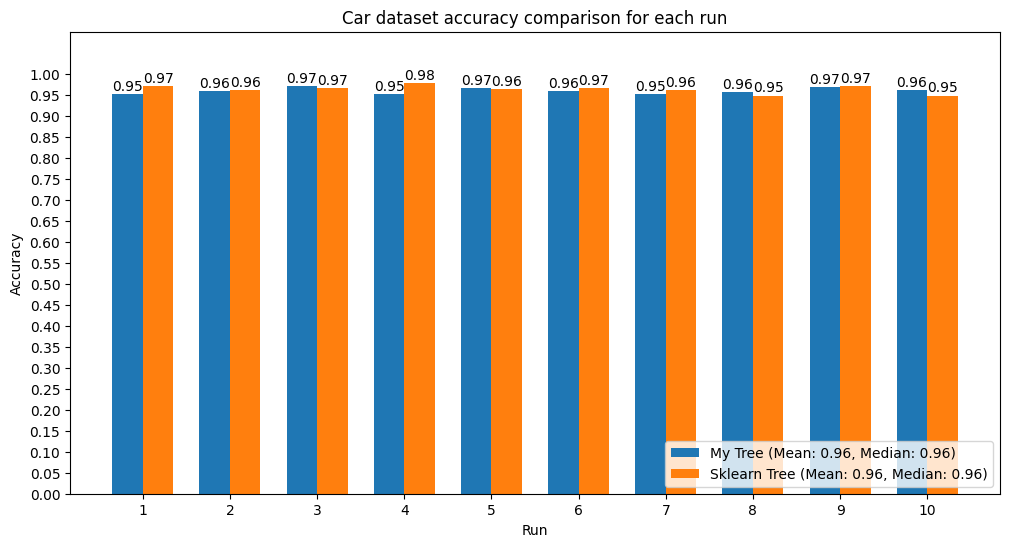

In [14]:
data_car = pd.read_csv("car.csv").to_numpy()

accuracies_my_tree = []
accuracies_sklearn_tree = []

# TODO: Set up the data and split it into train and test-sets.
data_car_features = data_car[:, :-1]
data_car_labels = data_car[:, -1]

for i in range(10):
    train_features, test_features, train_labels, test_labels = train_test_split(
        data_car_features,
        data_car_labels,
        test_size=0.25,
        train_size=0.75,
        shuffle=True,
    )

    data = np.column_stack((train_features, train_labels))

    # TODO: Train and test your implemented tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model
    predictions = []

    my_tree = grow_tree(data, 0, 10, criterion="gini")

    for feature_row in test_features:
        prediction = predict_with_tree(train_features, feature_row, my_tree)
        predictions.append(prediction)

    accuracy_my_tree = accuracy_score(test_labels, predictions)
    accuracies_my_tree.append(accuracy_my_tree)
    # TODO: Train and test scikit learns tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model

    encoder = OrdinalEncoder()
    train_features_enc = encoder.fit_transform(train_features)
    test_features_enc = encoder.transform(test_features)

    decision_tree_classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=2)
    decision_tree_classifier.fit(train_features_enc, train_labels)
    sklearn_predictions = decision_tree_classifier.predict(test_features_enc)
    accuracy_sklearn = accuracy_score(test_labels, sklearn_predictions)
    accuracies_sklearn_tree.append(accuracy_sklearn)
    print(
        f"My Tree Car Accuracy: {accuracy_my_tree:<20} Sklearn Tree Car Accuracy: {accuracy_sklearn:<20}"
    )

mean_accuracy_my_tree = np.mean(accuracies_my_tree)
median_accuracy_my_tree = np.median(accuracies_my_tree)
mean_accuracy_sklearn_tree = np.mean(accuracies_sklearn_tree)
median_accuracy_sklearn_tree = np.median(accuracies_sklearn_tree)

print(
    "\nMy Tree Car Mean and Median Accuracy:",
    ,
    median_accuracy_my_tree,
)
print(
    "Sklearn Tree Car Mean and Median Accuracy:",
    mean_accuracy_sklearn_tree,
    median_accuracy_sklearn_tree,
)

# TODO: Do the above at least 5 times
# NOTE: Use loops here!
mean_accuracy_my_tree
# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(12, 6))
x = np.arange(1, 11)
width = 0.35

plt.bar(
    x - width / 2,
    accuracies_my_tree,
    width,
    label=f"My Tree (Mean: {mean_accuracy_my_tree:.2f}, Median: {median_accuracy_my_tree:.2f})",
)
plt.bar(
    x + width / 2,
    accuracies_sklearn_tree,
    width,
    label=f"Sklearn Tree (Mean: {mean_accuracy_sklearn_tree:.2f}, Median: {median_accuracy_sklearn_tree:.2f})",
)

for i in range(10):
    plt.text(
        x[i] - width / 2,
        accuracies_my_tree[i] + 0.01,
        f"{accuracies_my_tree[i]:.2f}",
        ha="center",
    )
    plt.text(
        x[i] + width / 2,
        accuracies_sklearn_tree[i] + 0.01,
        f"{accuracies_sklearn_tree[i]:.2f}",
        ha="center",
    )

plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.title("Car dataset accuracy comparison for each run")
plt.xticks(x)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim([0, 1.1])
plt.legend(loc="lower right")
plt.show()

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

My Tree Wine Accuracy: 1.0                  My Tree Normalized Wine Accuracy: 0.8888888888888888  
My Tree Wine Accuracy: 0.9111111111111111   My Tree Normalized Wine Accuracy: 0.9111111111111111  
My Tree Wine Accuracy: 0.9111111111111111   My Tree Normalized Wine Accuracy: 0.9111111111111111  
My Tree Wine Accuracy: 0.9777777777777777   My Tree Normalized Wine Accuracy: 0.9555555555555556  
My Tree Wine Accuracy: 0.8                  My Tree Normalized Wine Accuracy: 0.8444444444444444  
My Tree Wine Accuracy: 0.9333333333333333   My Tree Normalized Wine Accuracy: 0.9111111111111111  
My Tree Wine Accuracy: 0.9777777777777777   My Tree Normalized Wine Accuracy: 0.8666666666666667  
My Tree Wine Accuracy: 0.8888888888888888   My Tree Normalized Wine Accuracy: 0.9777777777777777  
My Tree Wine Accuracy: 0.9333333333333333   My Tree Normalized Wine Accuracy: 0.9555555555555556  
My Tree Wine Accuracy: 0.9555555555555556   My Tree Normalized Wine Accuracy: 0.9333333333333333  

My Tree W

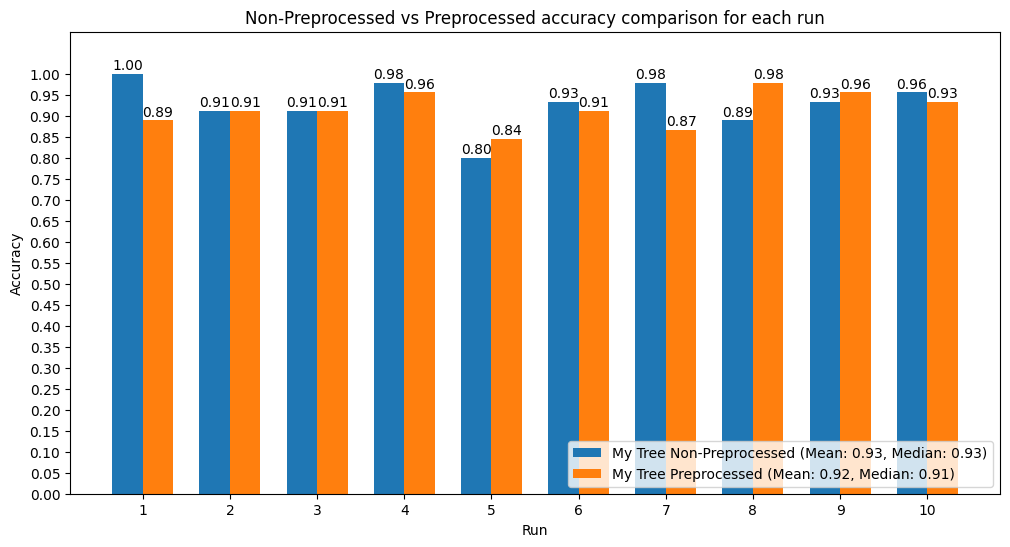

In [21]:
from sklearn import preprocessing

# TODO: Use the wine dataset from above and scale its features and labels between 0 and 1
# TODO: Run the code from the dataset and compare the preprocessed vs non-preprocessed data.
# NOTE: You can copy most of the workflow from the dataset code above to save you some time.
# NOTE: Use the same train/test split for your tree model for both the preprocessed vs non-preprocessed data.

accuracies_my_tree = []
accuracies_my_tree_norm = []

# TODO: Set up the data and split it into train and test-sets.

for _ in range(10):
    train_features, test_features, train_labels, test_labels = train_test_split(
        data_wine_features,
        data_wine_labels,
        test_size=0.25,
        train_size=0.75,
        shuffle=True,
    )

    data = np.column_stack((train_features, train_labels))

    train_features_norm = preprocessing.normalize(train_features)
    test_features_norm = preprocessing.normalize(test_features)

    data_norm = np.column_stack((train_features_norm, train_labels))

    # TODO: Train and test your implemented tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model
    predictions = []
    predictions_norm = []

    my_tree = grow_tree(data, 0, 10, criterion="entropy")
    my_tree_norm = grow_tree(data_norm, 0, 10, criterion="entropy")

    for feature_row in test_features:
        prediction = predict_with_tree(train_features, feature_row, my_tree)
        predictions.append(prediction)
    for feature_row in test_features_norm:
        prediction = predict_with_tree(train_features_norm, feature_row, my_tree_norm)
        predictions_norm.append(prediction)

    accuracy_my_tree = accuracy_score(test_labels, predictions)
    accuracies_my_tree.append(accuracy_my_tree)
    accuracy_my_tree_norm = accuracy_score(test_labels, predictions_norm)
    accuracies_my_tree_norm.append(accuracy_my_tree_norm)
    print(
        f"My Tree Wine Accuracy: {accuracy_my_tree:<20} My Tree Normalized Wine Accuracy: {accuracy_my_tree_norm:<20}"
    )

mean_accuracy_my_tree = np.mean(accuracies_my_tree)
median_accuracy_my_tree = np.median(accuracies_my_tree)
mean_accuracy_my_tree_norm = np.mean(accuracies_my_tree_norm)
median_accuracy_my_tree_norm = np.median(accuracies_my_tree_norm)

print(
    "\nMy Tree Wine Mean and Median Accuracy:",
    mean_accuracy_my_tree,
    median_accuracy_my_tree,
)
print(
    "My Tree Normalized Wine Mean and Median Accuracy:",
    mean_accuracy_my_tree_norm,
    median_accuracy_my_tree_norm,
)

# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough

plt.figure(figsize=(12, 6))
x = np.arange(1, 11)
width = 0.35

plt.bar(
    x - width / 2,
    accuracies_my_tree,
    width,
    label=f"My Tree Non-Preprocessed (Mean: {mean_accuracy_my_tree:.2f}, Median: {median_accuracy_my_tree:.2f})",
)
plt.bar(
    x + width / 2,
    accuracies_my_tree_norm,
    width,
    label=f"My Tree Preprocessed (Mean: {mean_accuracy_my_tree_norm:.2f}, Median: {median_accuracy_my_tree_norm:.2f})",
)

for i in range(10):
    plt.text(
        x[i] - width / 2,
        accuracies_my_tree[i] + 0.01,
        f"{accuracies_my_tree[i]:.2f}",
        ha="center",
    )
    plt.text(
        x[i] + width / 2,
        accuracies_my_tree_norm[i] + 0.01,
        f"{accuracies_my_tree_norm[i]:.2f}",
        ha="center",
    )

plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.title("Non-Preprocessed vs Preprocessed accuracy comparison for each run")
plt.xticks(x)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim([0, 1.1])
plt.legend(loc="lower right")
plt.show()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!